# Drug Reviews

## Install libraries

In [ ]:
import matplotlib.pyplot as plt #Data visualization

In [ ]:
#Tensorflow Modules
from tensorflow.keras.models import Sequential #sequebtial model
from tensorflow.keras.layers import Dense,LSTM,Embedding,Dropout #layers of the model
import tensorflow as tf #tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer #tokenize a sentence
from tensorflow.keras.preprocessing.sequence import pad_sequences #pad a sequence to fixed length

In [ ]:
#text preprocessing libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import PorterStemmer
import re

In [ ]:
import pandas as pd #data manipulation
import numpy as np #linear algerbra

In [ ]:
from google.colab import drive 
drive.mount('/content/drive') #mount google drive to load/save the model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plt.style.use("fivethirtyeight") #Define the style of vizualization

## Load and Explore the data

In [ ]:
train=pd.read_csv("/content/drugsComTrain_raw.csv")
test=pd.read_csv("/content/drugsComTest_raw.csv",error_bad_lines=False,warn_bad_lines=True)#There are some bad lines

In [ ]:
train.shape #data shape

(161297, 7)

In the data , there are 7 rows and 161297 rows

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


We are intrested only in the review and rating to conduct our nlp task

In [ ]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
train["review"][2] # an example of a review

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [ ]:
#number of drugs
len(train["drugName"].value_counts().keys())

3436

No handles with labels found to put in legend.


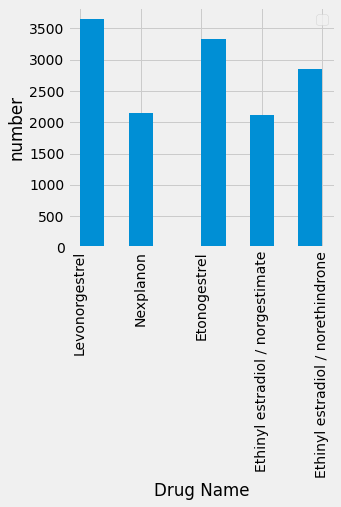

In [ ]:
#Visualzing the most used drugs
X=train.loc[train['drugName'].isin(list(train["drugName"].value_counts()[0:5].keys())),"drugName"]
plt.hist(X)
plt.legend()
plt.tight_layout()
plt.xticks(rotation="vertical")
plt.xlabel("Drug Name")
plt.ylabel("number")
plt.show()

Text(0, 0.5, 'Rating')

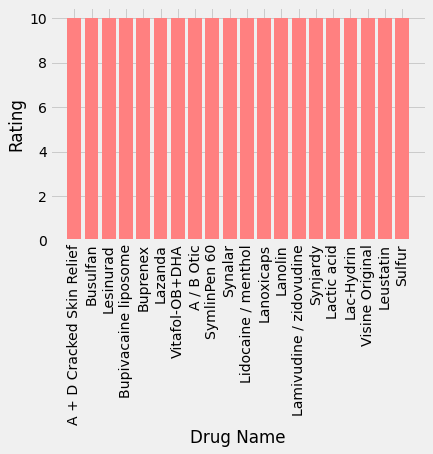

In [ ]:
#Visualzing top 20 best drugs by rating
X=train[["drugName","rating"]].groupby(by="drugName").mean().sort_values(by="rating",ascending=False)[0:20]
plt.bar(X.index,X["rating"],color="#ff8080")
plt.xticks(rotation="vertical")
plt.xlabel('Drug Name')
plt.ylabel("Rating")

Text(0, 0.5, 'Rating')

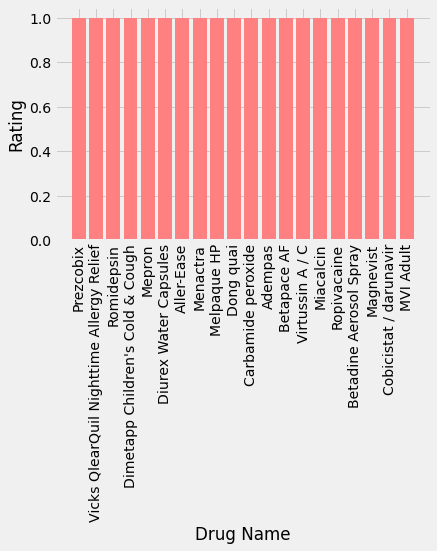

In [ ]:
#Visualzing top 5 worst drugs by rating
X=train[["drugName","rating"]].groupby(by="drugName").mean().sort_values(by="rating")[0:20]
plt.bar(X.index,X["rating"],color="#ff8080")
plt.xticks(rotation="vertical")
plt.xlabel('Drug Name')
plt.ylabel("Rating")

## Data preprocessing

In [ ]:
#remove the ' from the data
train["review"]=[re.sub("&#039;","'", u) for u in train['review']]
test["review"]=[re.sub("&#039;","'", u) for u in test['review']]

In [ ]:
#remove all special caracteres 
train["review"]=[re.sub('[^a-zA-Z ]+', '', _) for _ in train["review"]]
test["review"]=[re.sub('[^a-zA-Z ]+', '', _) for _ in test["review"]]

In [ ]:
#lower case all letters
train['review']=[x.lower() for  x in train['review']]
test['review']=[x.lower() for  x in test['review']]

In [ ]:
#initialize the Porter stemmer
ps = PorterStemmer()

In [ ]:
#download stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data_train=[]#the new train data
data_test=[]#the new test data
lens=[]#collect the length of every row
vocab=[]#collect the vocabulary of all the corpus
for el in train['review']:
  x=[]
  for word in word_tokenize(el):
    if word not in stop_words:#remove stop words
      x.append(ps.stem(word))#apply stemmer 
  lens.append(len(x))#add the length of the text
  data_train.append(" ".join(x))
  vocab.extend(x)#add the vocab
for el in test['review']:
  x=[]
  for word in word_tokenize(el):
    if word not in stop_words:
      x.append(ps.stem(word))
  data_test.append(" ".join(x))



(array([11555., 19553., 23421., 23198., 20699., 19377., 28732., 13513.,
          909.,    94.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

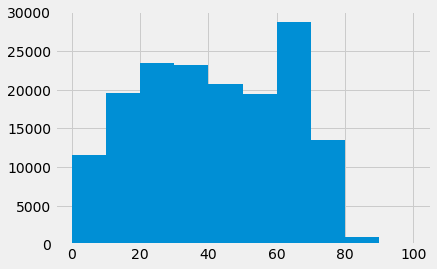

In [ ]:
plt.hist(lens,range=[0,100]) # plot a histogram of the length of the corpus

In [ ]:
#take max length accepted as the length that 90% of the sentences does not surpass
max_length=int(np.quantile(lens,0.9))

In [ ]:
vocab=list(set(vocab)) #remove duplicate
vocab_size=int(len(vocab)*0.95) #accepte 95% of vocabulary and 5% will be considered as out-of-vocabulary-token
vocab_size

61791

In [ ]:
#initialize the tokenizer
tokenizer=Tokenizer(num_words=vocab_size,oov_token="<OOV>")

In [ ]:
#fit the tokenizer
tokenizer.fit_on_texts(data_train)

In [ ]:
word_index=tokenizer.word_index
word_index

{'<OOV>': 1,
 'take': 2,
 'day': 3,
 'month': 4,
 'year': 5,
 'effect': 6,
 'work': 7,
 'get': 8,
 'week': 9,
 'start': 10,
 'im': 11,
 'pain': 12,
 'side': 13,
 'feel': 14,
 'time': 15,
 'ive': 16,
 'mg': 17,
 'first': 18,
 'like': 19,
 'pill': 20,
 'use': 21,
 'period': 22,
 'tri': 23,
 'help': 24,
 'go': 25,
 'would': 26,
 'medic': 27,
 'one': 28,
 'doctor': 29,
 'back': 30,
 'also': 31,
 'took': 32,
 'weight': 33,
 'got': 34,
 'medicin': 35,
 'sinc': 36,
 'dont': 37,
 'life': 38,
 'stop': 39,
 'still': 40,
 'bad': 41,
 'realli': 42,
 'much': 43,
 'anxieti': 44,
 'control': 45,
 'never': 46,
 'hour': 47,
 'last': 48,
 'depress': 49,
 'went': 50,
 'sleep': 51,
 'better': 52,
 'sever': 53,
 'two': 54,
 'even': 55,
 'felt': 56,
 'gain': 57,
 'night': 58,
 'well': 59,
 'everi': 60,
 'good': 61,
 'didnt': 62,
 'great': 63,
 'cramp': 64,
 'drug': 65,
 'make': 66,
 'dose': 67,
 'thing': 68,
 'ago': 69,
 'prescrib': 70,
 'acn': 71,
 'birth': 72,
 'made': 73,
 'littl': 74,
 'put': 75,
 'almo

In [ ]:
#transform text to sequences
sequences_train=tokenizer.texts_to_sequences(data_train)
sequences_test=tokenizer.texts_to_sequences(data_test)

In [ ]:
#pad sequences to fixed length with zeros
padded_train=pad_sequences(sequences_train,maxlen=max_length)
padded_test=pad_sequences(sequences_test,maxlen=max_length)
padded_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   13,    6,    2,  495, 2174,
         17, 2447, 1192], dtype=int32)

In [ ]:
#expand the dimension of the training set to be accepted by keras
X_train= np.expand_dims( np.array(padded_train),axis=2)
X_train.shape

(161297, 69, 1)

In [ ]:
Y_train=train['rating']-1# to facilitate the transformation into one-hot encoding using tensorflow utils
Y_train.value_counts() 

9    50989
8    27531
0    21619
7    18890
6     9456
4     8013
1     6931
2     6513
5     6343
3     5012
Name: rating, dtype: int64

In [ ]:
#expand the dimension of the test set to be accepted by keras
X_test=np.expand_dims( np.array(padded_test),axis=2)
X_test.shape

(53766, 69, 1)

In [ ]:
Y_test=test['rating']-1# to facilitate the transformation into one-hot encoding using tensorflow utils
Y_test.value_counts()

9    17016
8     9177
0     7299
7     6156
6     3091
4     2710
1     2334
2     2205
5     2119
3     1659
Name: rating, dtype: int64

In [ ]:
Y_train_2=Y_train.copy()#make a copy to be used in 4_class classification
Y_train_3=Y_train.copy()#make a copy to be used in 4_class classification

In [ ]:
Y_test_2=Y_test.copy()#make a copy to be used in 2_class classification
Y_test_3=Y_test.copy()#make a copy to be used in 2_class classification

## 10 classe clasification






In [ ]:
#One-hot encoding 
Y_train_1=tf.keras.utils.to_categorical(Y_train,num_classes=10)
Y_test_1=tf.keras.utils.to_categorical(Y_test,num_classes=10)

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size,128,input_length=max_length)) #add and embedding layer
model.add(LSTM(32)) #LSTM with 32 units
model.add(Dense(10,activation="softmax")) #softmax for classification
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 69, 128)           7909248   
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 7,930,186
Trainable params: 7,930,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy()#use categorical cross entropy as loss function
              ,optimizer="adam", # use adam as optimizer with default parameters
              metrics="accuracy"# we use accuracy as metric
              )

In [ ]:
#train the model
model.fit(X_train,Y_train_1,epochs=9,batch_size=32,validation_data=(X_test,Y_test_1))

Epoch 1/9
5041/5041 [==============================] - 643s 128ms/step - loss: 0.1147 - accuracy: 0.9656 - val_loss: 2.4350 - val_accuracy: 0.6924
Epoch 2/9
5041/5041 [==============================] - 650s 129ms/step - loss: 0.1066 - accuracy: 0.9676 - val_loss: 2.4753 - val_accuracy: 0.6997
Epoch 3/9
5041/5041 [==============================] - 650s 129ms/step - loss: 0.1007 - accuracy: 0.9695 - val_loss: 2.5257 - val_accuracy: 0.7005
Epoch 4/9
5041/5041 [==============================] - 650s 129ms/step - loss: 0.0946 - accuracy: 0.9720 - val_loss: 2.5796 - val_accuracy: 0.6961
Epoch 5/9
5041/5041 [==============================] - 651s 129ms/step - loss: 0.0881 - accuracy: 0.9737 - val_loss: 2.6151 - val_accuracy: 0.7020
Epoch 6/9
5041/5041 [==============================] - 652s 129ms/step - loss: 0.0846 - accuracy: 0.9743 - val_loss: 2.7155 - val_accuracy: 0.7010
Epoch 7/9
5041/5041 [==============================] - 651s 129ms/step - loss: 0.0801 - accuracy: 0.9764 - val_loss: 2

In [ ]:
#save the model
model.save("/content/drive/MyDrive/drugReviews2.h5")

## 4 classe classification

In [ ]:
for i,_ in Y_train_2.iteritems():
  if _ <3:Y_train_2[i]=0
  if _ >=3 and _<5:Y_train_2[i]=1
  if _ >=5 and _<8:Y_train_2[i]=2
  if _ >=8:Y_train_2[i]=3

In [ ]:
for i,_ in Y_test_2.iteritems():
  if _ <3:Y_test_2[i]=0
  if _ >=3 and _<5:Y_test_2[i]=1
  if _ >=5 and _<8:Y_test_2[i]=2
  if _ >=8:Y_test_2[i]=3

In [ ]:
#One-hot encoding
Y_train_2=tf.keras.utils.to_categorical(Y_train_2,num_classes=4)
Y_test_2=tf.keras.utils.to_categorical(Y_test_2,num_classes=4)

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size,128,input_length=max_length))
model.add(LSTM(32))
model.add(Dropout(0.4))
model.add(Dense(4,activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 69, 128)           7909248   
                                                                 
 lstm_2 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 7,929,988
Trainable params: 7,929,988
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer="adam",metrics="accuracy")

In [ ]:
model.fit(X_train,Y_train_2,epochs=10,batch_size=32,validation_data=(X_test,Y_test_2))

Epoch 1/10
5041/5041 [==============================] - 612s 121ms/step - loss: 0.2107 - accuracy: 0.9252 - val_loss: 0.9403 - val_accuracy: 0.7796
Epoch 2/10
5041/5041 [==============================] - 616s 122ms/step - loss: 0.1942 - accuracy: 0.9320 - val_loss: 0.9585 - val_accuracy: 0.7814
Epoch 3/10
5041/5041 [==============================] - 603s 120ms/step - loss: 0.1781 - accuracy: 0.9376 - val_loss: 0.9724 - val_accuracy: 0.7878
Epoch 4/10
5041/5041 [==============================] - 607s 120ms/step - loss: 0.1647 - accuracy: 0.9432 - val_loss: 0.9888 - val_accuracy: 0.7903
Epoch 5/10
5041/5041 [==============================] - 607s 120ms/step - loss: 0.1522 - accuracy: 0.9479 - val_loss: 1.0853 - val_accuracy: 0.7893
Epoch 6/10
5041/5041 [==============================] - 604s 120ms/step - loss: 0.1441 - accuracy: 0.9497 - val_loss: 1.0751 - val_accuracy: 0.7936
Epoch 7/10
5041/5041 [==============================] - 609s 121ms/step - loss: 0.1339 - accuracy: 0.9544 - val_

In [ ]:
model.save("/content/drive/MyDrive/drugReviews_4Classes.h5")

## 2 class classification

In [ ]:
for i,_ in Y_train_3.iteritems():
  if _ <5:Y_train_3[i]=0
  if _ >=5:Y_train_3[i]=1

In [ ]:
for i,_ in Y_test_3.iteritems():
  if _ <5:Y_test_3[i]=0
  if _ >=5:Y_test_3[i]=1

In [ ]:
#One-hot encoding
Y_train_3=tf.keras.utils.to_categorical(Y_train_3,num_classes=2)
Y_test_3=tf.keras.utils.to_categorical(Y_test_3,num_classes=2)

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size,128,input_length=max_length))
model.add(LSTM(32))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 69, 128)           7909248   
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 7,929,922
Trainable params: 7,929,922
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer="adam",metrics="accuracy")

In [ ]:
model.fit(X_train,Y_train_3,epochs=10,batch_size=32,validation_data=(X_test,Y_test_3))

Epoch 1/10
5041/5041 [==============================] - 623s 123ms/step - loss: 0.3915 - accuracy: 0.8279 - val_loss: 0.3497 - val_accuracy: 0.8478
Epoch 2/10
5041/5041 [==============================] - 616s 122ms/step - loss: 0.2937 - accuracy: 0.8774 - val_loss: 0.3215 - val_accuracy: 0.8658
Epoch 3/10
5041/5041 [==============================] - 617s 122ms/step - loss: 0.2286 - accuracy: 0.9078 - val_loss: 0.3064 - val_accuracy: 0.8777
Epoch 4/10
5041/5041 [==============================] - 618s 123ms/step - loss: 0.1768 - accuracy: 0.9308 - val_loss: 0.3285 - val_accuracy: 0.8822
Epoch 5/10
5041/5041 [==============================] - 617s 122ms/step - loss: 0.1350 - accuracy: 0.9492 - val_loss: 0.3306 - val_accuracy: 0.8932
Epoch 6/10
5041/5041 [==============================] - 616s 122ms/step - loss: 0.1076 - accuracy: 0.9599 - val_loss: 0.3564 - val_accuracy: 0.8979
Epoch 7/10
5041/5041 [==============================] - 617s 122ms/step - loss: 0.0864 - accuracy: 0.9685 - val_

In [ ]:
model.save("/content/drive/MyDrive/drugReviews_2Classes.h5")